In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [2]:
BATCH_SIZE = 16
IMAGE_SIZE = 128
CHANNELS=3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/young-affectnet-hq",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 14648 files belonging to 8 classes.


In [4]:
class_names = dataset.class_names
class_names

['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

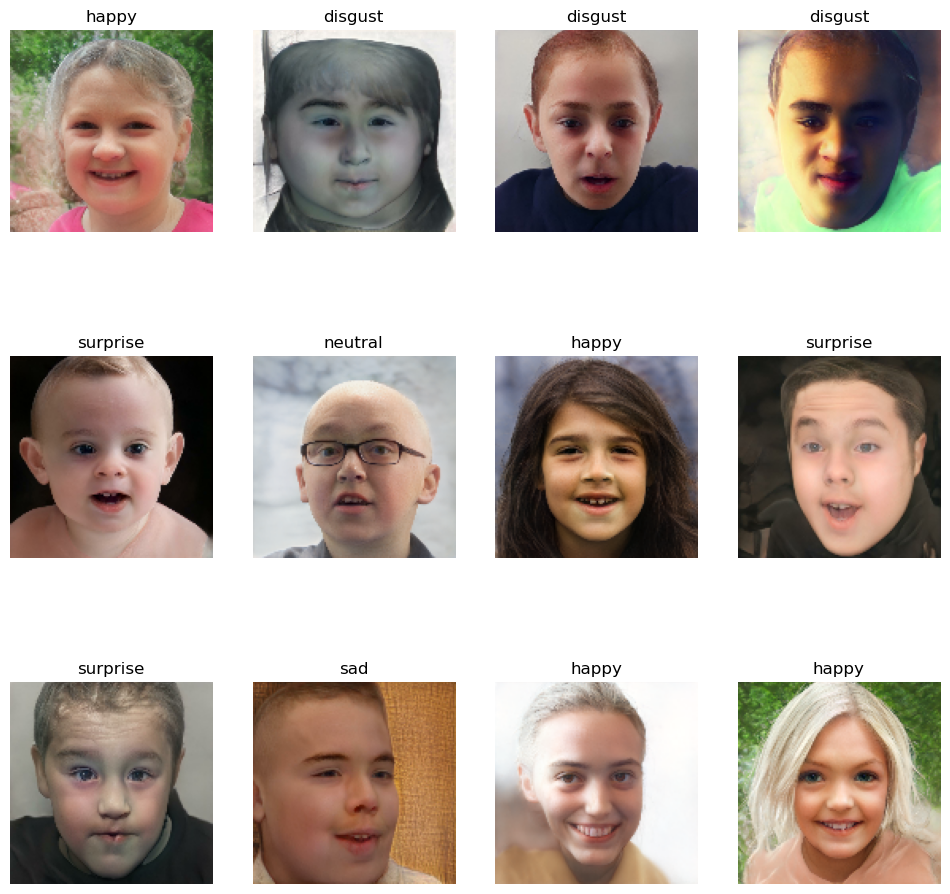

In [5]:
plt.figure(figsize=(12, 12))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [6]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

732
91
93


In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
from tensorflow.keras import models, layers
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [10]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 8

model = models.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [11]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)     

In [12]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
)

Epoch 1/100
732/732 [==============================] - 319s 206ms/step - loss: 2.9395 - accuracy: 0.1329 - val_loss: 2.0734 - val_accuracy: 0.1312
Epoch 2/100
732/732 [==============================] - 6s 8ms/step - loss: 2.0772 - accuracy: 0.1400 - val_loss: 2.0677 - val_accuracy: 0.1319
Epoch 3/100
732/732 [==============================] - 6s 8ms/step - loss: 2.0944 - accuracy: 0.1346 - val_loss: 2.0736 - val_accuracy: 0.1387
Epoch 4/100
732/732 [==============================] - 6s 8ms/step - loss: 2.0824 - accuracy: 0.1329 - val_loss: 2.0648 - val_accuracy: 0.1463
Epoch 5/100
732/732 [==============================] - 6s 8ms/step - loss: 2.0720 - accuracy: 0.1393 - val_loss: 2.0590 - val_accuracy: 0.1518
Epoch 6/100
732/732 [==============================] - 6s 8ms/step - loss: 2.0703 - accuracy: 0.1376 - val_loss: 2.0663 - val_accuracy: 0.1401
Epoch 7/100
732/732 [==============================] - 6s 9ms/step - loss: 2.0718 - accuracy: 0.1396 - val_loss: 2.0604 - val_accuracy: 0.

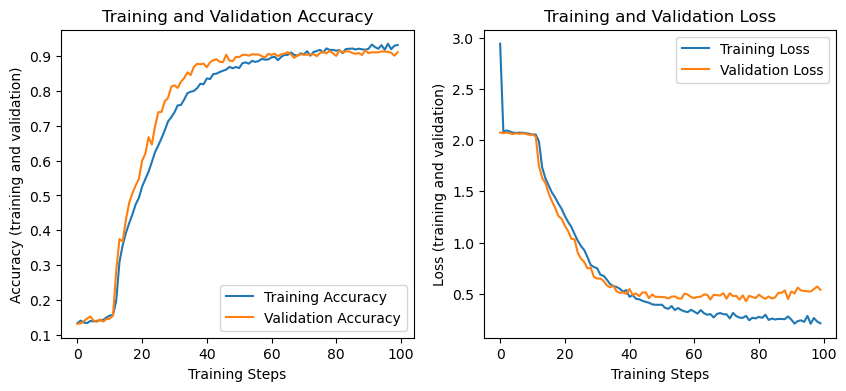

In [13]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [14]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get the true labels and predicted labels for the test set
y_true = []
y_pred = []
for x, y in test_ds:
    y_true.extend(y.numpy())
    y_pred.extend(np.argmax(model.predict(x), axis=-1))

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print(cm)

1/1 [==============================] - 0s 27ms/step
[[150   2   5   1   0   0   3   5]
 [  4 176   5   1   0   0   2   2]
 [  6   1 178   3   0   1   4   3]
 [  2   2   1 172   1   0   5   8]
 [  0   2   0   0 167   5   1   1]
 [  0   1   0   1   5 189   1   1]
 [  2   4   1   3   0   1 160   3]
 [  6   2   5   7   0   6   2 169]]


In [ ]:
model.save("rohit1.h5")